<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_15_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lesson 15: introduction to decomposition methods for data exploration and feature selection

Welcome to Lesson 15 of the North Carolina Institute for Climate Studies' Machine Learning Course. Here, we'll examine how to use several kinds of decomposition methods to explore and manipulate the data. These methods are considered subsets of unsupervised machine learning, but they are distinct from clustering and outlier detection, which are the two other categories most users associate with the term "unsupervised learning". Speciically, we'll examine **principal component analysis**, **independent component analysis**, and **factor analysis**.

## Notes on how to use this notebook:

This notebook utilizes these decomposition methods to explore the Asheville USCRN data set. Accordingly, you should feel free to play around and actually explore the data! By selecting different combinations of input features and different numbers of output components, you'll start to notice relationships between the different observed data. Some of these relationships could just be correlation/uncorrelation, but others may include causal effects. **The point of using these kinds of methods to explore a data set is to develop a more intuitive understanding of how the data are structured.** Such an understanding often helps to inform more rigorous and effective downstream analyses in supervised learning problems, via feature selection/engineering and learner optimization. Have fun! (And be patient with the plotting methods - they'll take a minute or so sometimes, b/c they're plotting a lot of data using Google's Colab cloud services. For faster plotting, you could pull this notebook and its associated USCRN data to your local machine)

## About the data set:

We'll be using the data set is derived from the US Climate Reference Network that we've seen in earlier notebooks.

Check the *USCRN_Daily_Data_readme.txt* file in the repository for a complete description of this dataset.

# Preprocess the data

We will be using a new data set from the US Climate Reference Network's Asheville station. Let's load and preprocess it.

In [6]:
# Import all of the major libraries that we'll be using.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import additional modules, objects, and functions that we'll use.
from datetime import datetime

# Define the path and names of our data files.
path_data_dir =\
  "./ML4ES-tutorials/00-Data/USCRN-data/"
filename_data = "USCRN-NC_Asheville_8_SSW_2001-2019.csv"

# Clone the data from the GitHub repo and then check which files are present.
try:
    ! git clone https://github.com/geo-yrao/ML4ES-tutorials.git
    ! ls $path_data_dir
except:
    ! ls $path_data_dir

Cloning into 'ML4ES-tutorials'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 412 (delta 17), reused 15 (delta 6), pack-reused 372
Receiving objects: 100% (412/412), 6.05 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (215/215), done.
README.md		     USCRN-NC_Asheville_8_SSW_2001-2019.csv
USCRN_Daily_Data_readme.txt  USCRN-NC_Asheville_8_SSW_2010-2019.csv


## Ingest the data 

We will ingest the data and keep the following fields as our features: `T_DAILY_AVG, P_DAILY_CALC, SOLARAD_DAILY, SUR_TEMP_DAILY_AVG, RH_DAILY_AVG`, plus the soil moisture readings. There are more interesting observed variables, though, so feel free to include those columns if you'd like. 

In [29]:
# Use pandas's read_csv() function to import the data. Stipulate that the first
# column as the dataframe's index.
df = pd.read_csv(path_data_dir+filename_data, index_col="LST_DATE")

# Subset to columns-of-interest and use dates as dataframe index.
cols_to_keep_data = [
    "T_DAILY_AVG", "P_DAILY_CALC", "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", "RH_DAILY_AVG"
]
cols_to_keep_soil_moisture = [
    "SOIL_MOISTURE_5_DAILY",
    "SOIL_MOISTURE_10_DAILY",
    "SOIL_MOISTURE_20_DAILY"
]
df_data = df[cols_to_keep_data]
df_soil_moisture = df[cols_to_keep_soil_moisture]

# Get rid of rows with NaN values. 
df_data = df_data.dropna()
df_soil_moisture = df_soil_moisture.loc[df_data.index] # Keep only the intersection of the sets.
df_soil_moisture = df_soil_moisture.dropna()
df_data = df_data.loc[df_soil_moisture.index] # Keep only the intersection of the sets.

# Reindex the dataframe using the dates converted into datetime objects.
dates_list = [datetime.strptime(str(d),'%Y%m%d') for d in df_data.index]
df_data.index = dates_list
df_soil_moisture.index = dates_list

In [58]:
# Have a peek at the non-soil moisture fields, just so we know what it looks like.
df_data.head()

T_DAILY_AVG  P_DAILY_CALC  ...  SUR_TEMP_DAILY_AVG  RH_DAILY_AVG
2010-01-20          6.1           0.5  ...                 6.0          88.9
2010-01-21          3.5          12.1  ...                 3.9          95.8
2010-01-22          3.0           0.5  ...                 4.0          95.2
2010-01-23          3.6           0.3  ...                 4.1          93.6
2010-01-24          6.6          71.5  ...                 6.2          94.6

[5 rows x 5 columns]

In [59]:
# Preview the soil moisture data, for the same reason.
df_soil_moisture.head()

SOIL_MOISTURE_5_DAILY  ...  SOIL_MOISTURE_20_DAILY
2010-01-20                  0.354  ...                   0.324
2010-01-21                  0.380  ...                   0.348
2010-01-22                  0.390  ...                   0.356
2010-01-23                  0.363  ...                   0.329
2010-01-24                  0.419  ...                   0.350

[5 rows x 3 columns]

## Explore USCRN Asheville station data

We will explore the USCRN soil moisture data by plotting the various features. We will then calculate the correlation values between both features and the soil moisture targets. These correlations can give us an idea of which features may hold hold redundant information.  Be sure to compare the pairwise plots with the follwoing correlation matrix: it will help you gain an intuitive understanding of what 2D correlations "look like".

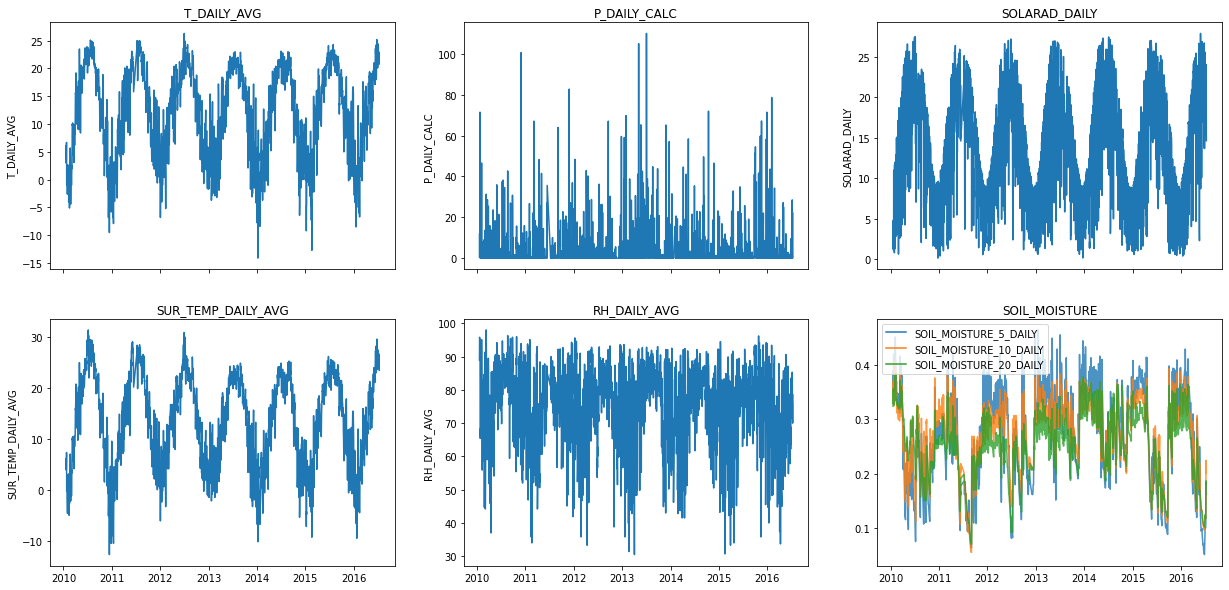

In [81]:
# Make a quick plot of all the features to gain some understanding as to their characteristics.
fig, ax = plt.subplots(2, 3, figsize=(21, 10), sharex=True)
x = [i for i in range(1, df_data.shape[0]+1)]
for i in range(2):
    for j in range(3):
        idx = i*3+j
        current_ax = ax[i,j]
        if idx==5:
            continue
        sns.lineplot(data=df_data.iloc[:, idx], ax=current_ax)
        current_ax.set_title(df_data.columns[idx])

sns.lineplot(data=df_soil_moisture, ax=ax[1,2], dashes=False, alpha=0.8)
current_ax.set_title("SOIL_MOISTURE")

plt.show()

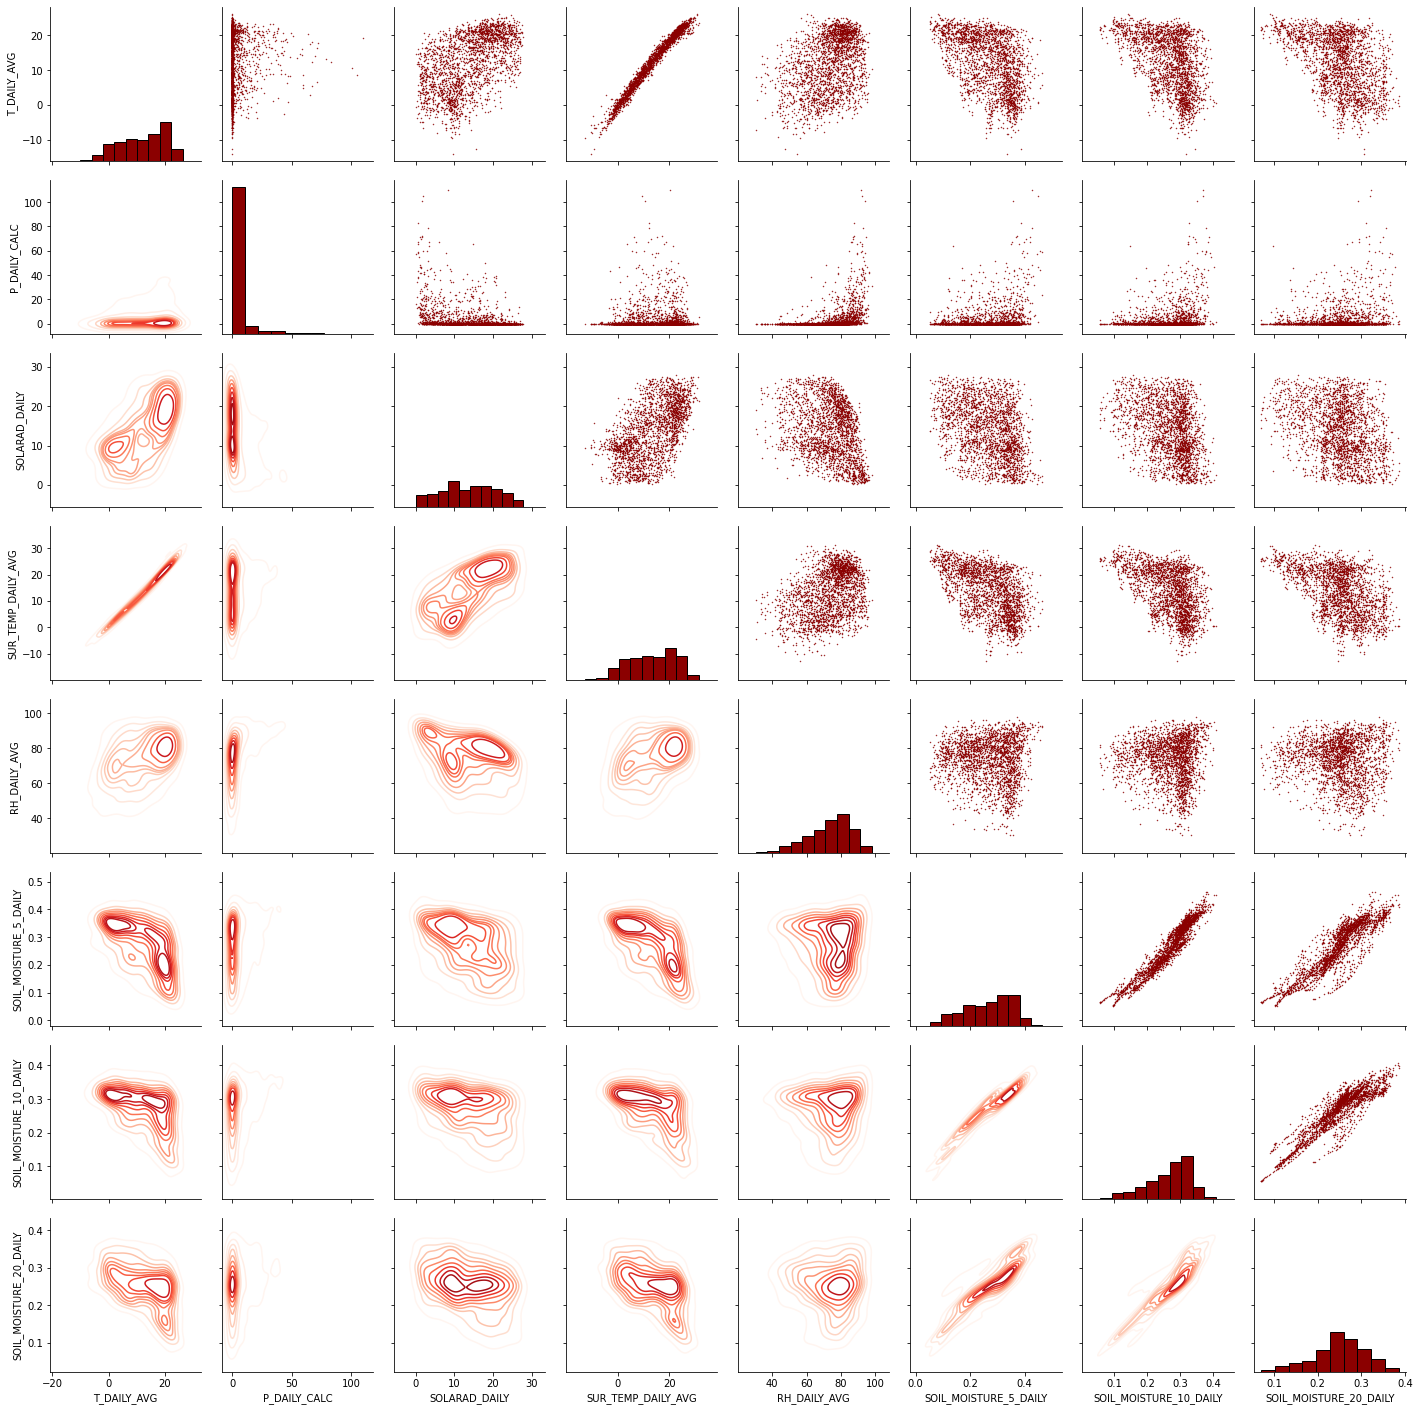

In [82]:
# Combine the feature and target dataframes so as to easily calculate their
# correlation coefficients.
df_combined = pd.concat([df_data, df_soil_moisture], axis=1)

# Perform pairwise plotting of the variables to look for obvious two-dimensional 
# covariance structures. seaborn.pairplot() isn't quite as descriptive as
# seaborn.PairGrid(), which I've opted to use below, but it is a good bit faster.
# Feel free to uncomment and use it if you're bored by the execution time.
# sns.pairplot(df_combined)
# plt.show()

# I found out about this nifty Seaborn function from this excellent blog post:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
# It take about a minute to plot, but it's well worth the wait.
grid = sns.PairGrid(df_combined)

# Plot scatter plots above the diagonal.
grid = grid.map_upper(plt.scatter, color="darkred", s=0.2)

# Plot histograms on the diagonal.
grid = grid.map_diag(plt.hist, color="darkred", edgecolor="k")

# Plot density contours below the diagonal.
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap="Reds")

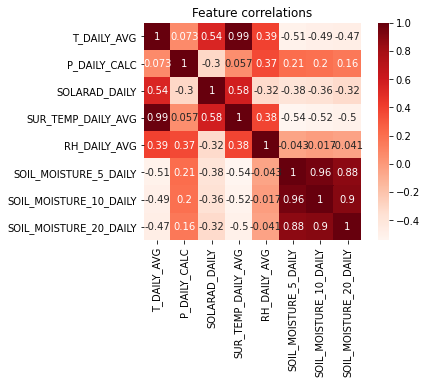

In [ ]:
# Calculate the correlations matrix between the variables.
correlations_matrix = np.corrcoef(df_combined.values.T)
combined_cols_list = df_data.columns.to_list() + df_soil_moisture.columns.to_list()

# Plot the correlation matrix.
ax = seaborn.heatmap(
    correlations_matrix, cmap="Reds", annot=True, square=True, cbar=True,
    xticklabels=combined_cols_list, yticklabels=combined_cols_list,
)
ax.set_title("Feature correlations")

plt.show()

Be sure to look back and compare the correlation matrix above with the pairwise plots of the variables. You can generally see where correlations are occuring.

# Principal component analysis

Time to explore the data set with principal component analysis. Remember, PCA creates new, uncorrelated features by mapping the original features into a new orthogonal basis in such a way that the variances in from the original data set are maximized.

This technique is really effective when dealing with Gaussian-distributed data (thank you, [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)), but just because certain combinations of features explain a lot of the variance doesn't necessarily indicate that those combinations are meaningful.

To determine that, it helps to have domain knowledge about the data at hand.

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

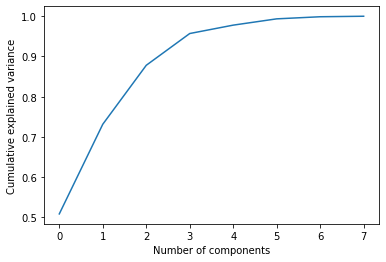

In [36]:
# Decide whether or not to scale the data (always a good idea) and
# which features to process using PCA. I've included the scaling option so you
# can get a feel for what happens when you have features with very different
# magnitudes and distribution statistics. If most of your features are of the same 
# magnitude, then scaling isn't necessary. Otherwise, larger features can dominate
# the resulting PCA analysis. 
scale = True
cols_to_keep_PCA = [
    "T_DAILY_AVG", 
    "P_DAILY_CALC", 
    "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", 
    "RH_DAILY_AVG",
    "SOIL_MOISTURE_5_DAILY",
    "SOIL_MOISTURE_10_DAILY",
    "SOIL_MOISTURE_20_DAILY",
]
df_for_pca = df_combined[cols_to_keep_PCA]

if scale:
  # Scale the data first, since some of the features have much, much larger
  # magnitudes than others.
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(df_for_pca)

  # Perform PCA on the scaled data.
  pca = PCA()
  X_pca = pca.fit_transform(X_scaled)
else:
  # Perform PCA on the unscaled data.
  pca = PCA()
  X_pca = pca.fit_transform(df_for_pca)

# Plot the explained variance of the PCA-transformed data.
fig, ax = plt.subplots(1,1)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance")
fig.show()

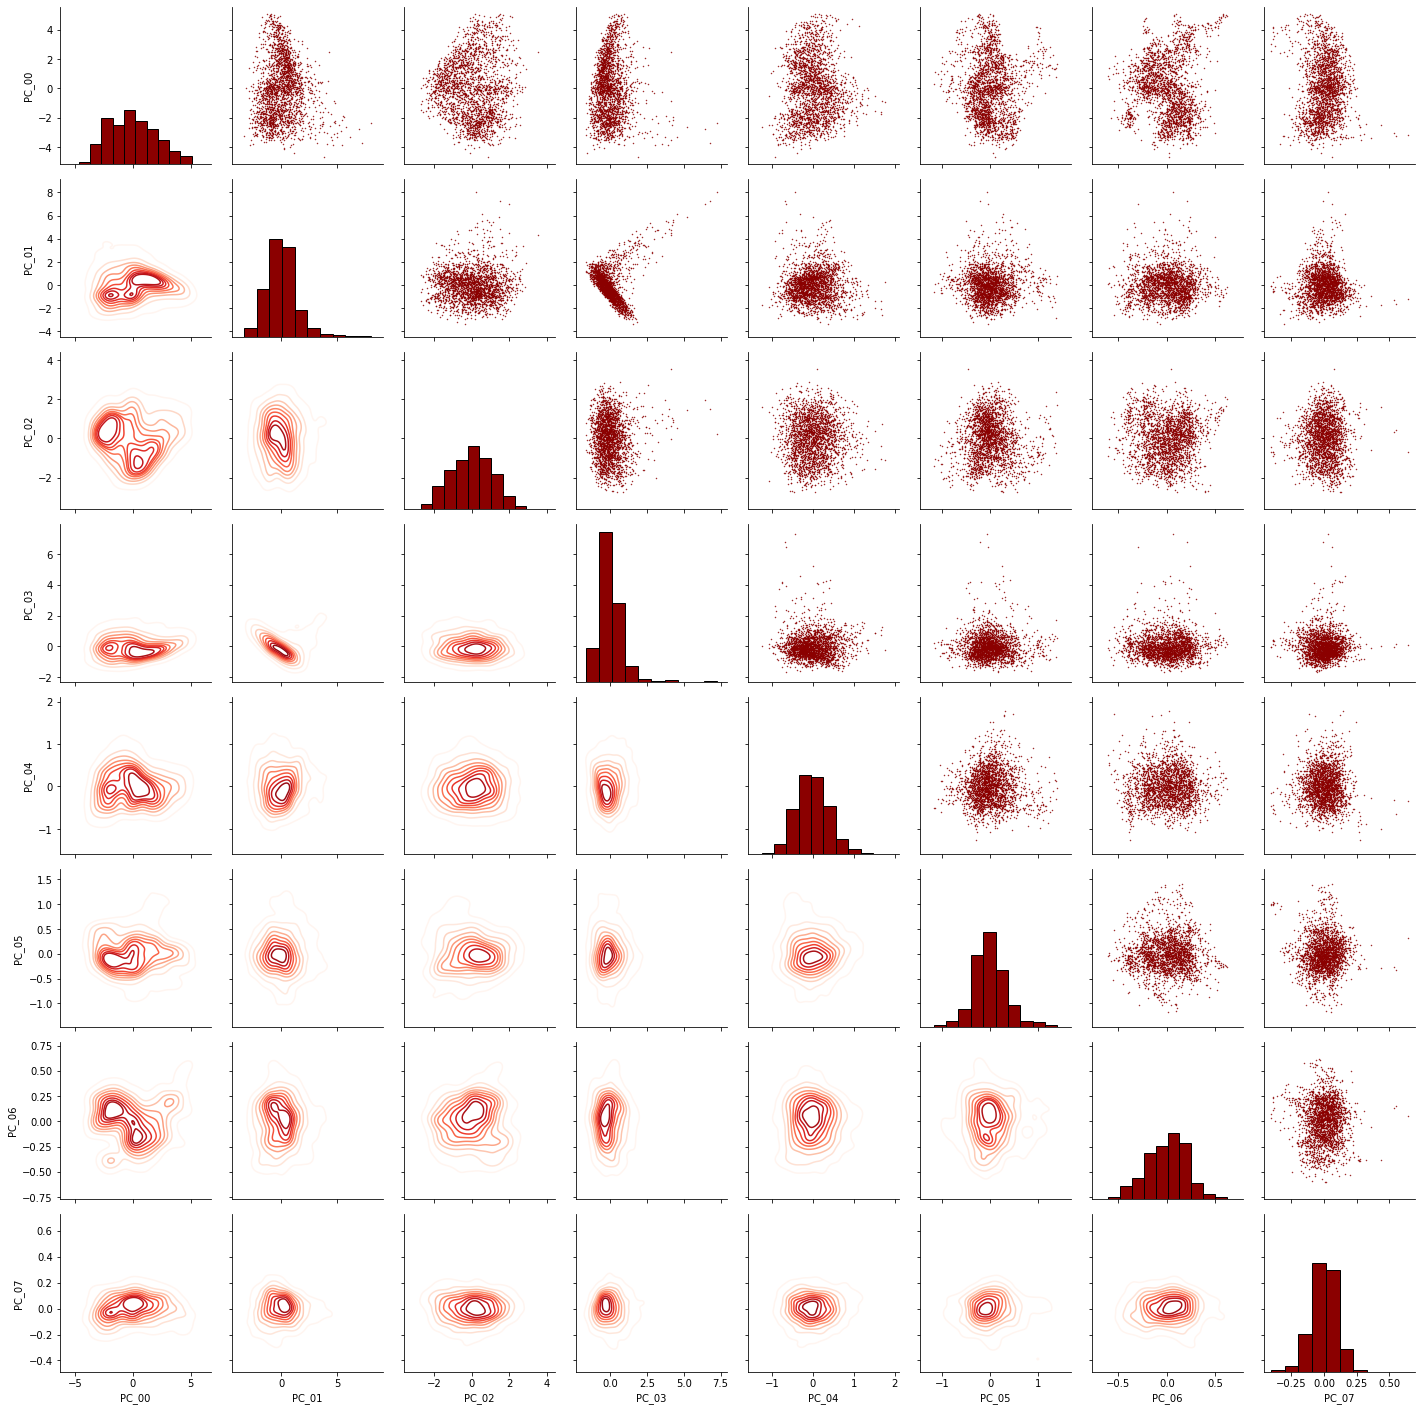

In [37]:
# Perform pairwise plotting of the variables to look for obvious 
# two-dimensional covariance structures. These should be greatly reduced, since
# PCA creates maximally-decorrelated new features. 
df_PCA = pd.DataFrame(
    data=X_pca, 
    columns=["PC_"+str(i).zfill(2) for i in range(len(cols_to_keep_PCA))]
    )

# Use seaborn's nifty PairGrid plot to plot the different distributions.
grid = sns.PairGrid(df_PCA)
grid = grid.map_upper(plt.scatter, color="darkred", s=0.2)
grid = grid.map_diag(plt.hist, bins=10, color="darkred", edgecolor="k")
grid = grid.map_lower(sns.kdeplot, cmap="Reds")
plt.show()

# Independent component analysis

Now analyze the data using ICA. This decomposition method requires that the resulting components are statistically independent from one another, which is a much stronger requirement than that they just be uncorrelated. 

In order to do that, the user has to sacrifice orthogonality of the resulting components. Additionally, there's no obvious ordering of the independent components, unlike in PCA. In PCA, we can use the components' eigenvalue magnitudes (ie, the magnitude of their variances) to order them from most-to-least "important". Note: you can actually order the independent components using a higher-order correlation called kurtosis (4th order cumulant), but that's beyond the scope of this introductory notebook.

ICA can thus be trickier to use, but also can give more meaninful results for the phenomena of physical systems that are often "signals" of some sort (think climatic signals, etc.) that have been processed through the physical system. ICA requires that the user be a bit more saavy, but can correspondingly give the user deeper insights into what's generating their observed variables.

In [38]:
from sklearn.decomposition import FastICA

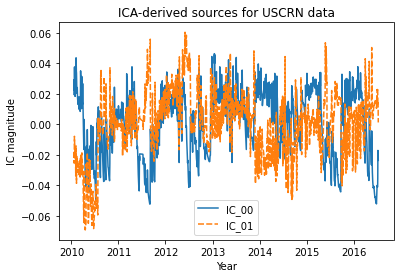

In [83]:
# Decide on the number of independent components to generate. If left to its own
# devices, ICA will generate as many ICs as there are input features. Here, I 
# initially chose to look for two generating signals, with the hope that they
# might look similar to two of the input features (ie, daily precipitation and 
# daily temperature might combine to give us a good indicator as to the soil moisture
# on a given day).
num_sources = 2

# Decide which features to process using ICA. I played a lot with processing
# soil moisture data to see if I could recover daily temperature and precipitation
# information from them.
cols_to_keep_ICA = [
    # "T_DAILY_AVG", 
    # "P_DAILY_CALC", 
    # "SOLARAD_DAILY",
    # "SUR_TEMP_DAILY_AVG", 
    # "RH_DAILY_AVG",
    "SOIL_MOISTURE_5_DAILY",
    "SOIL_MOISTURE_10_DAILY",
    "SOIL_MOISTURE_20_DAILY",
]
df_for_ICA = df_combined[cols_to_keep_ICA]

# Initialize and run the ICA. We don't need to scale the data, since this ICA
# algorithm performs "statistical whitening", which includes the scaling step.
ica = FastICA(n_components=num_sources)
X_ICA = ica.fit_transform(df_for_ICA)
df_ICA = pd.DataFrame(
    data=X_ICA,
    columns=["IC_"+str(i).zfill(2) for i in range(num_sources)],
    index=df_combined.index
    )

# Make a quick plot of all the resulting independent components to gain a sense
# of their structure.
fig, ax = plt.subplots(1, 1,)
sns.lineplot(data=df_ICA, ax=ax)
ax.set_title("ICA-derived sources for USCRN data")
ax.set_xlabel("Year")
ax.set_ylabel("IC magnitude")
plt.show()

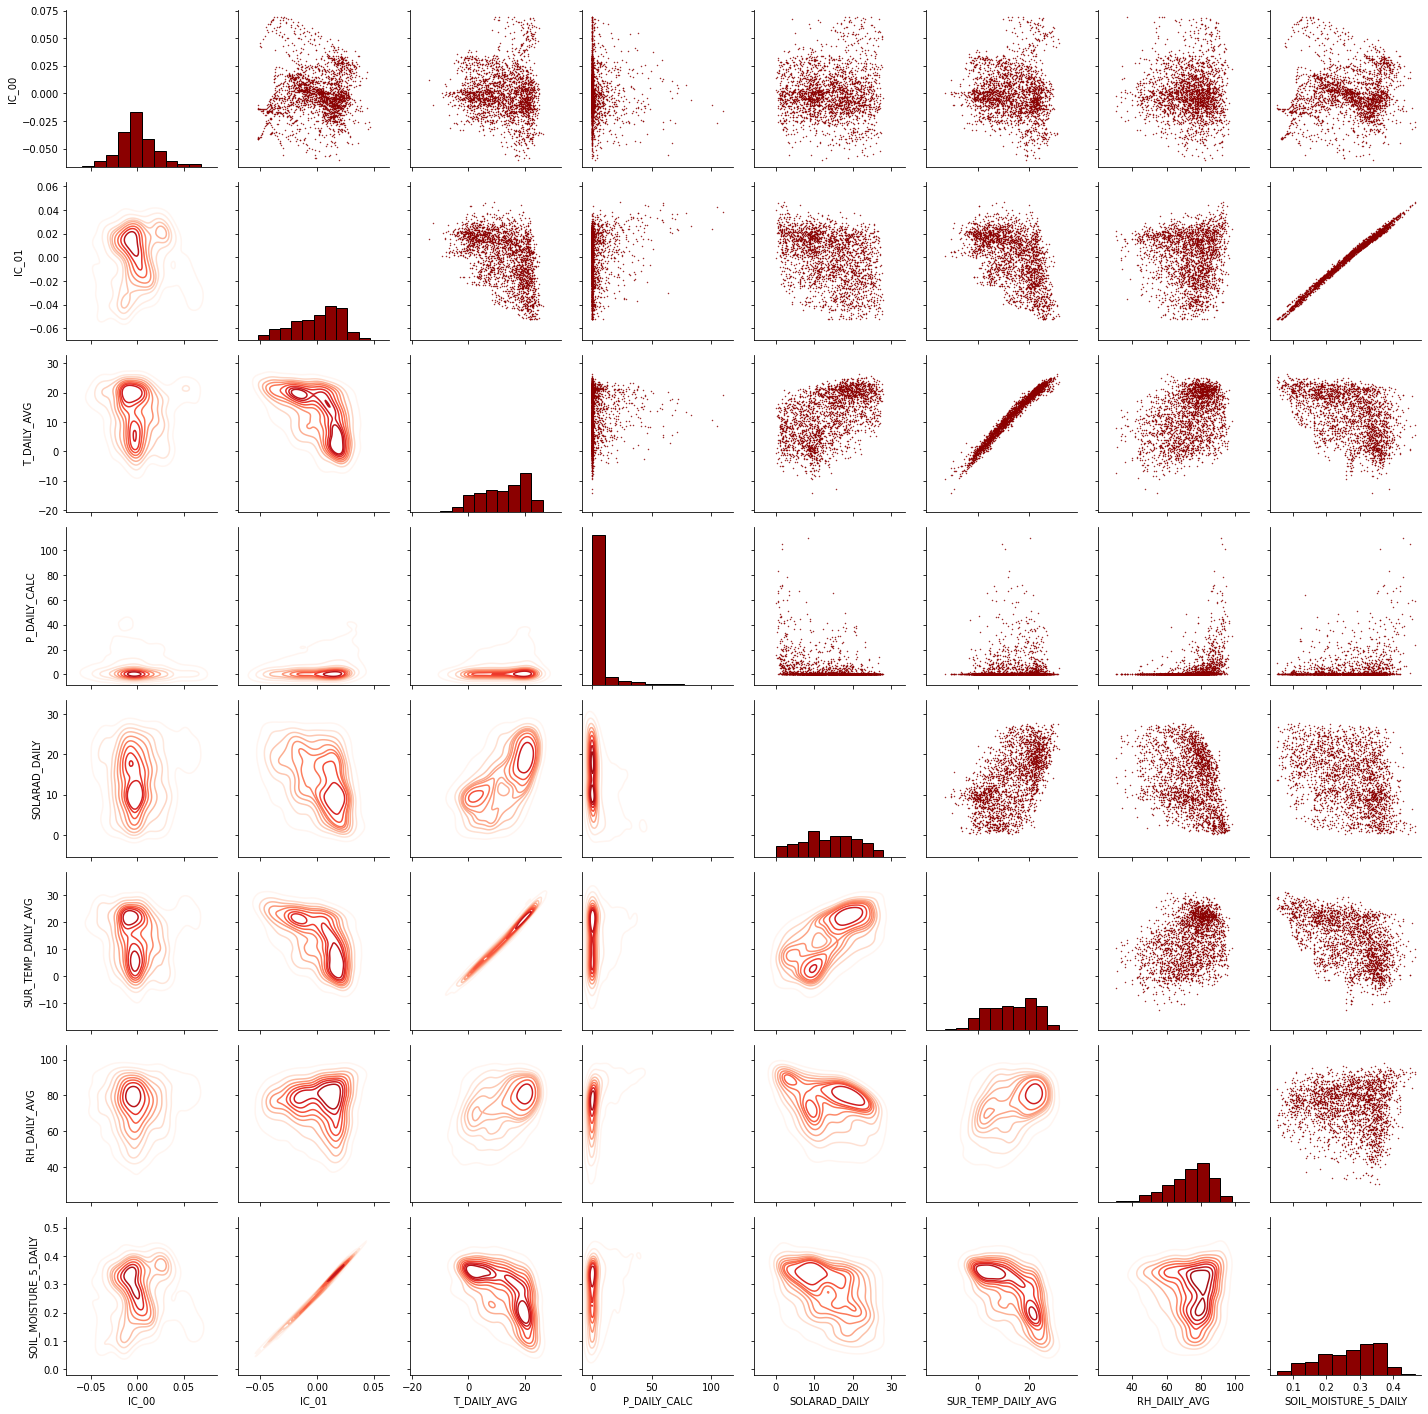

In [57]:
# Choose which columns to plot pairwise against the independent components.
cols_to_keep_ICA_plotting = [
    "T_DAILY_AVG", 
    "P_DAILY_CALC", 
    "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", 
    "RH_DAILY_AVG",
    "SOIL_MOISTURE_5_DAILY",
    # "SOIL_MOISTURE_10_DAILY",
    # "SOIL_MOISTURE_20_DAILY",
]

# Combine the IC's with your features of interest and then plot them to see if  
# any are correlated together. If they are, then there's a decent chance that  
# the ICA identified those input features as driving forces behind the 
# generation of our features-of-interest.
df_combined_ICA = pd.concat(
    [df_ICA, df_combined[cols_to_keep_ICA_plotting]], 
    axis=1
    )
grid = sns.PairGrid(df_combined_ICA)
grid = grid.map_upper(plt.scatter, color="darkred", s=0.2)
grid = grid.map_diag(plt.hist, color="darkred", edgecolor="k")
grid = grid.map_lower(sns.kdeplot, cmap="Reds")

# Factor analysis

Finally, we'll explore the data set using factor analysis decomposition. Factor analysis is quite good at dealing with features whose structures include [heteroscedatic noise](https://en.wikipedia.org/wiki/Heteroscedasticity). This kind of noise can occur a lot in fields where instrumentation are subject to all sorts of nonlinear noise phenomena (ie, meteorology and climatology). 

The set up is quite similar to that for ICA. Play around and see what you can discover. I've set up an FA versus ICA comparison plot further down so you can examine the differences between the outputs of the two methods.

In [64]:
from sklearn.decomposition import FactorAnalysis

# Define the number of latent factors you'd like the model to output. 
num_factors = 2

# Define the columns you'd like the FA to analyze.
cols_to_keep_FA = [
    "T_DAILY_AVG", 
    "P_DAILY_CALC", 
    "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", 
    "RH_DAILY_AVG",
    "SOIL_MOISTURE_5_DAILY",
    "SOIL_MOISTURE_10_DAILY",
    "SOIL_MOISTURE_20_DAILY",
]
df_for_FA = df_combined[cols_to_keep_FA]

# Scale the data first, since some of the features have much, much larger
# magnitudes than others. This is similar to PCA.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_for_FA)

# Perform factor analysis on the scaled data.
factor_analysis = FactorAnalysis(n_components=num_factors)
X_FA = factor_analysis.fit_transform(X_scaled)

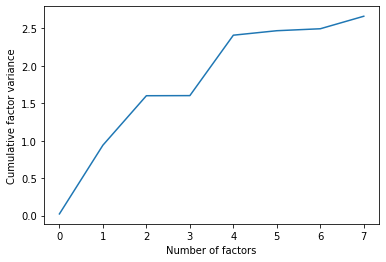

In [68]:
# Plot the cumulative variance of the latent variables.
fig, ax = plt.subplots(1,1)
ax.plot(np.cumsum(factor_analysis.noise_variance_ ))
ax.set_xlabel("Number of factors")
ax.set_ylabel("Cumulative factor variance")
fig.show()

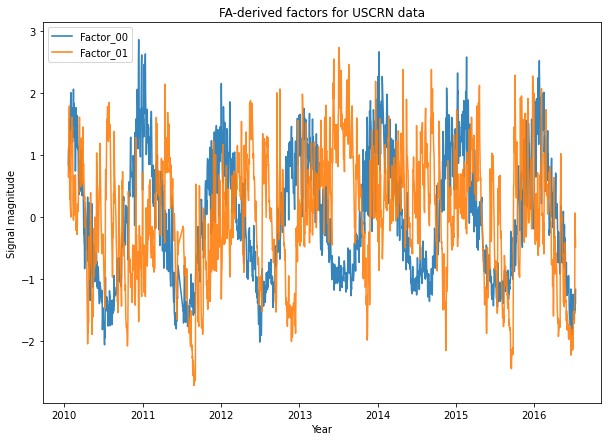

In [84]:
# Make a quick plot of all the latent variables to gain some understanding as 
# to their characteristics.
df_FA = pd.DataFrame(
    data=X_FA,
    columns=["Factor_"+str(i).zfill(2) for i in range(num_sources)],
    index=df_combined.index
    )
fig, ax = plt.subplots(1, 1, figsize=(10,7))
sns.lineplot(data=df_FA, ax=ax, dashes=False, alpha=0.9)
ax.set_title("FA-derived factors for USCRN data")
ax.set_xlabel("Year")
ax.set_ylabel("Signal magnitude")
plt.show()

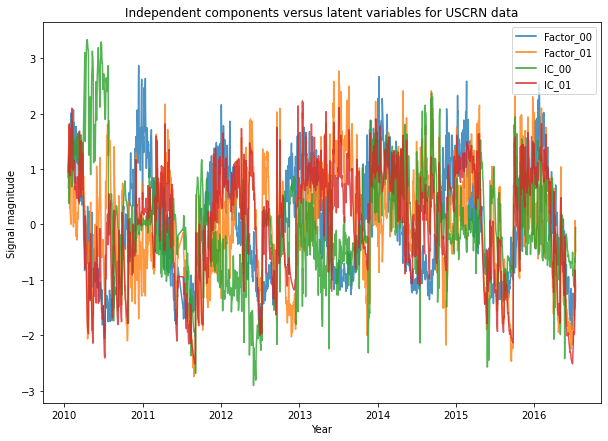

In [77]:
# Now compair the latent variables from the factor analysis with the independent
# components from the preceding IC analysis. You'll probably see some similarities.
df_FA_vs_ICA = pd.concat([df_FA, df_ICA], axis=1)
df_FA_vs_ICA = pd.DataFrame(
    data=StandardScaler().fit_transform(df_FA_vs_ICA.values),
    columns=df_FA_vs_ICA.columns,
    index=df_FA_vs_ICA.index,
)
fig, ax = plt.subplots(1, 1, figsize=(10,7))
sns.lineplot(data=df_FA_vs_ICA, ax=ax, dashes=False, alpha=0.8)
ax.set_title("Independent components versus latent variables for USCRN data")
ax.set_xlabel("Year")
ax.set_ylabel("Signal magnitude")
plt.show()

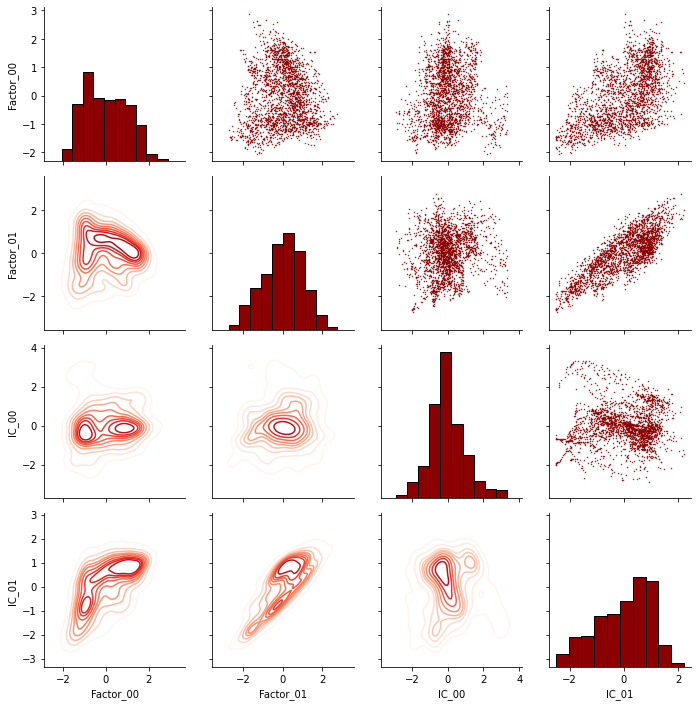

In [85]:
# Pairwise plot the independent components against the latent variables to
# gain a feeling for whether any are correlated.
grid = sns.PairGrid(df_FA_vs_ICA)
grid = grid.map_upper(plt.scatter, color="darkred", s=0.2)
grid = grid.map_diag(plt.hist, color="darkred", edgecolor="k")
grid = grid.map_lower(sns.kdeplot, cmap="Reds")

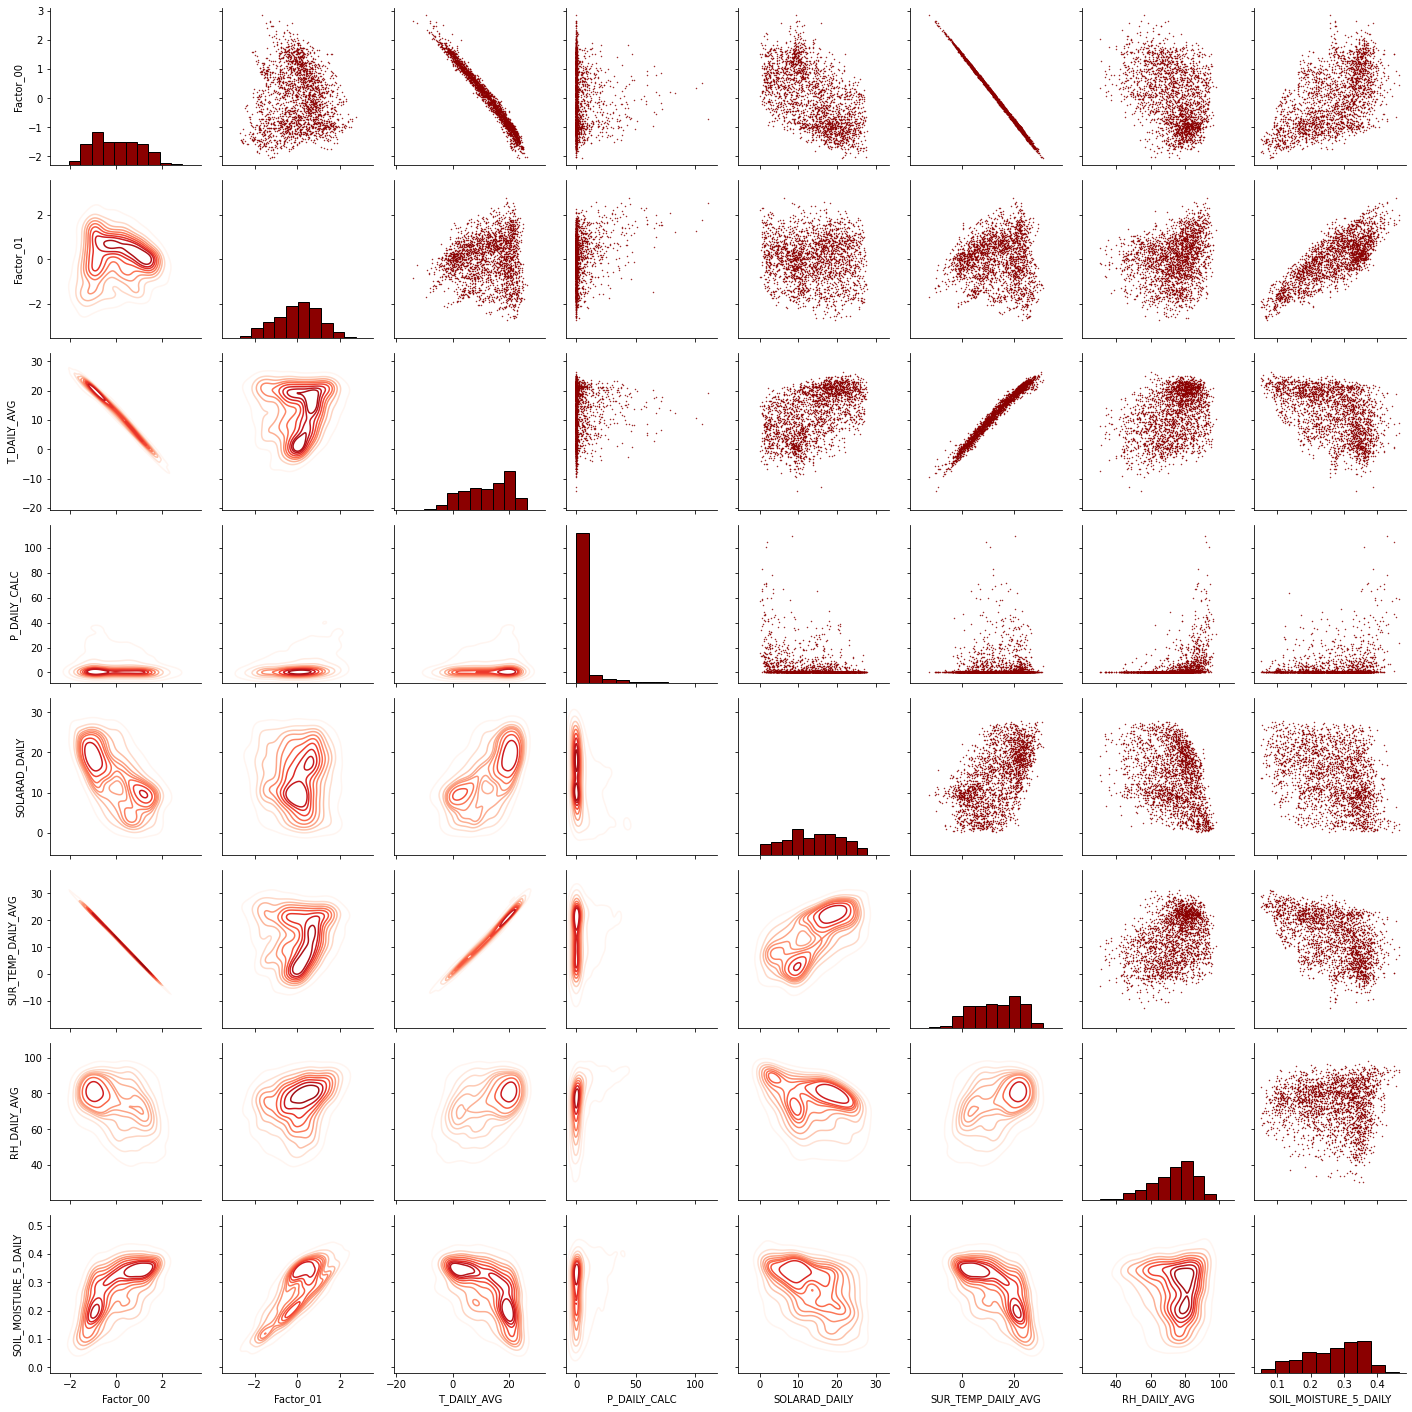

In [79]:
# Now plot the latent variables against the observed features. These plots can 
# help facilitate an understanding as to whether the FA extracted any of the 
# excluded features.

# Choose which columns to plot pairwise against the latent variables.
cols_to_keep_FA_plotting = [
    "T_DAILY_AVG", 
    "P_DAILY_CALC", 
    "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", 
    "RH_DAILY_AVG",
    "SOIL_MOISTURE_5_DAILY",
    # "SOIL_MOISTURE_10_DAILY",
    # "SOIL_MOISTURE_20_DAILY",
]

# Combine the latent variables with the observed data.
df_combined_FA = pd.concat(
    [df_FA, df_combined[cols_to_keep_FA_plotting]], 
    axis=1
    )

# Pairwise plot the latent variables against the observed features.
grid = sns.PairGrid(df_combined_FA)
grid = grid.map_upper(plt.scatter, color="darkred", s=0.2)
grid = grid.map_diag(plt.hist, color="darkred", edgecolor="k")
grid = grid.map_lower(sns.kdeplot, cmap="Reds")